In [42]:
import os
from scipy.io import loadmat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
import mne
import funcs4eeg as fe
import re
import imp
import ast
imp.reload(fe)

<module 'funcs4eeg' from 'c:\\Users\\Tianyi Zheng\\OneDrive - neuron.t.u-tokyo.ac.jp\\Documents\\zheng\\mywork\\attention_tES\\tes-attention\\processing\\eeg_analysis\\funcs4eeg.py'>

In [43]:
real_to_pick = [1, 3, 5, 9, 18]	
sham_to_pick = [6, 10, 11, 15, 16]
bands = [[8, 12], [12.5, 30], [30, 80]]
band_names = ['alpha', 'beta', 'gamma']

band_power = pd.DataFrame(columns=['band name', 'f low', 'f high', 'sham before', 
                                      'sham after', 'sham increase %', 'real before', 'real after', 'real increase %'])
band_power['band name'] = band_names
band_power['f low'] = [band[0] for band in bands]
band_power['f high'] = [band[1] for band in bands]

In [44]:
case='1'
watch='1 fixation'
tmin = 0
tmax = 3.5

for band_name in band_names:
    fmin = band_power[band_power['band name'] == band_name]['f low'].values[0]
    fmax = band_power[band_power['band name'] == band_name]['f high'].values[0]

    real_before = list()
    real_after = list()
    real_increase = list()
    for subject_id in real_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        real_before.append(power_before)
        real_after.append(power_after)
        real_increase.append((power_after - power_before)/power_before*100)
    band_power.loc[band_power['band name'] == band_name, 'real before'] = str(real_before)
    band_power.loc[band_power['band name'] == band_name, 'real after'] = str(real_after)
    band_power.loc[band_power['band name'] == band_name, 'real increase %'] = str(real_increase)


    sham_before = list()
    sham_after = list()
    sham_increase = list()
    for subject_id in sham_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        sham_before.append(power_before)
        sham_after.append(power_after)
        sham_increase.append((power_after - power_before)/power_before*100)
    band_power.loc[band_power['band name'] == band_name, 'sham before'] = str(sham_before)
    band_power.loc[band_power['band name'] == band_name, 'sham after'] = str(sham_after)
    band_power.loc[band_power['band name'] == band_name, 'sham increase %'] = str(sham_increase)


In [45]:
display(band_power)

,band name,f low,f high,sham before,sham after,sham increase %,real before,real after,real increase %
0,alpha,8.0,12,"[1.8003007099545222e-08, 1.613651511055436e-07...","[3.074686750708803e-08, 1.25286958271319e-07, ...","[70.78739866666349, -22.358106807477306, -30.9...","[4.097446427441903e-08, 8.358469051330054e-08,...","[4.300884005870357e-08, 8.063410177324591e-08,...","[4.964984461199248, -3.5300588205026773, -17.9..."
1,beta,12.5,30,"[4.243291931519124e-08, 4.810734637443832e-08,...","[3.516121405554799e-08, 3.25586648716175e-08, ...","[-17.13694314932495, -32.32080477230928, -3.34...","[4.154990478057896e-08, 4.607885333926513e-08,...","[3.7422357041279456e-08, 4.145157411314245e-08...","[-9.933952342602668, -10.042088486997232, 8.54..."
2,gamma,30.0,80,"[4.3882364700966945e-08, 2.154648378371025e-08...","[4.2643119769203446e-08, 1.9567879069644725e-0...","[-2.824015843740966, -9.182958732048, -13.3110...","[4.463174864047172e-08, 6.685417288685632e-08,...","[2.1728110241524347e-08, 2.3631395015771593e-0...","[-51.31691922592191, -64.65232610720463, -13.1..."


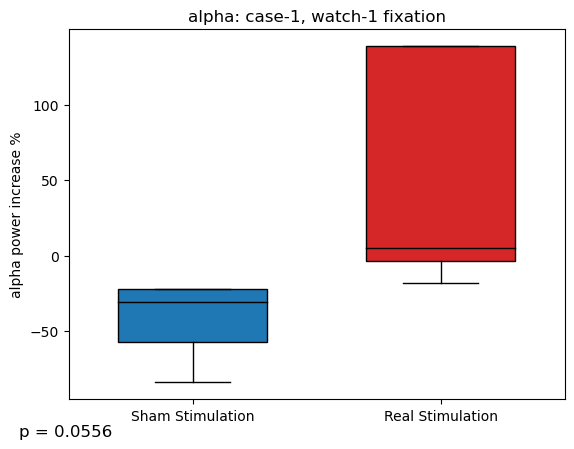

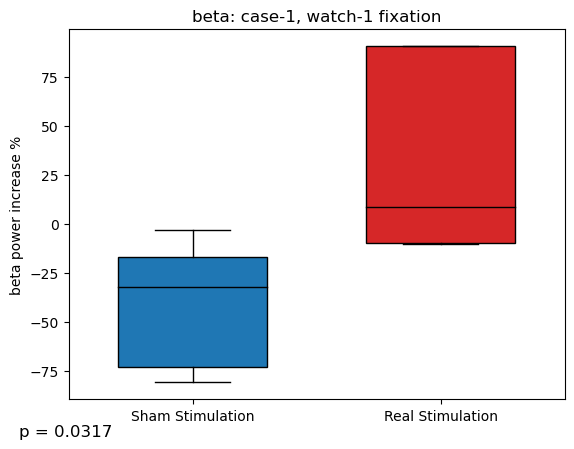

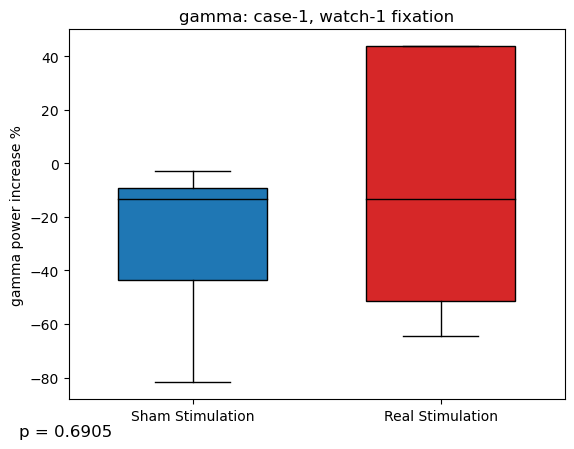

In [46]:
compare_objects = ['alpha', 'beta', 'gamma']
for compare_object in compare_objects:
    save_path = os.path.join('..', '..', '..', 'docs', 'report', 'figs', case+"_"+watch+"_"+compare_object+'.png')

    diff_sham = np.array(band_power.loc[band_power['band name'] == compare_object, 'sham increase %'].apply(ast.literal_eval).values[0])
    diff_real = np.array(band_power.loc[band_power['band name'] == compare_object, 'real increase %'].apply(ast.literal_eval).values[0])
    
    # create boxplot
    # Create a box plot with whiskers
    fig, ax = plt.subplots()
    boxplots = ax.boxplot([diff_sham, diff_real], patch_artist=True, widths=0.6, showfliers=False)

    # Set colors for the box plots
    colors = ['#1f77b4', '#d62728']
    for patch, color in zip(boxplots['boxes'], colors):
        patch.set_facecolor(color)

    # Set median line color to black
    for median in boxplots['medians']:
        median.set_color('black')

    plt.xticks([1, 2], ['Sham Stimulation', 'Real Stimulation'])
    plt.ylabel(compare_object+' power increase %')
    plt.title(compare_object+": case-"+case+", watch-"+watch)

    # Perform the Mann-Whitney U test
    U, p_value = stats.mannwhitneyu(diff_sham, diff_real)

    # Add the p-value to the plot
    ax.annotate(f'p = {p_value:.4f}',
                xy=(-0.1, -0.1),
                xycoords=('axes fraction', 'axes fraction'),
                ha='left', fontsize=12)
    # plt.savefig(save_path, format='png')

    plt.show()